This notebook has been migrated based on the author's TF v1 [[code link]](https://github.com/ratschlab/dpsom/tree/master/som_vae).

So far, it is only available for image samples such as MNIST in fashion MNIST.

Some part of the SOM-VAE is implemented for sequence or time-series datasets, but the whole is before migration from TF v1.

### Requirements

* tensorflow-gpu $\ge$ 2.6

# Library

In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import functools
from tqdm import tqdm
from collections import Counter

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

# Data loading

If you want to test with fashion MNIST, remark the line 1 and remove the hash the line 2

(3000, 30)
(60000, 1)


Text(0.5, 1.0, 'observations')

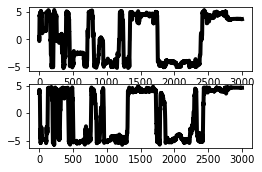

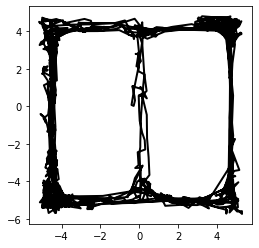

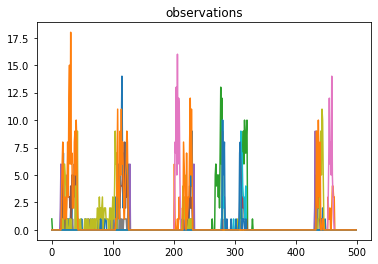

In [15]:
Time = 3000
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_3000.mat")
y_data = datax["spike30_sim_3000"] 
traj = scipy.io.loadmat("trj30_sim_3000.mat")
traj = traj["trj30_sim_3000"]
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
# mnist = tf.keras.datasets.fashion_mnist.load_data() 
print(y_data.shape)
data_total = np.reshape(mnist[0][0], [-1,28*28])
maxx = np.reshape(np.amax(data_total, axis = -1), [-1,1])
print(maxx.shape)
data_total = np.reshape(data_total/maxx, [-1,28,28,1])
labels_total = mnist[0][1]

data_train, data_val, labels_train, labels_val = train_test_split(data_total, labels_total, test_size = 0.25, random_state = 42)
data_test = np.reshape(mnist[1][0], [-1,28*28])
maxx = np.reshape(np.amax(data_test, axis = -1), [-1,1])
data_test = np.reshape(data_test/maxx, [-1,28,28,1])
data_test.shape

data_val=data_test
labels_val=mnist[1][1]
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj [:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj [:, 1], lw=4, color='k')

plt.figure(figsize=(4, 4))
plt.plot(*traj.T, lw = 2, color='k')
plt.figure()
plt.plot(y_data[:500,:12])
plt.title('observations')

# Batch generator

According to [the paper](https://arxiv.org/abs/1806.02199), they set up the data loader which generates non-time series data like time series.

In [3]:
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if not time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

def interpolate_arrays(arr1, arr2, num_steps=100, interpolation_length=0.3):
    """Interpolates linearly between two arrays over a given number of steps.
    The actual interpolation happens only across a fraction of those steps.
    Args:
        arr1 (np.array): The starting array for the interpolation.
        arr2 (np.array): The end array for the interpolation.
        num_steps (int): The length of the interpolation array along the newly created axis (default: 100).
        interpolation_length (float): The fraction of the steps across which the actual interpolation happens (default: 0.3).
    Returns:
        np.array: The final interpolated array of shape ([num_steps] + arr1.shape).
    """
    assert arr1.shape == arr2.shape, "The two arrays have to be of the same shape"
    start_steps = int(num_steps*interpolation_length)
    inter_steps = int(num_steps*((1-interpolation_length)/2))
    end_steps = num_steps - start_steps - inter_steps
    interpolation = np.zeros([inter_steps]+list(arr1.shape))
    arr_diff = arr2 - arr1
    for i in range(inter_steps):
        interpolation[i] = arr1 + (i/(inter_steps-1))*arr_diff
    start_arrays = np.concatenate([np.expand_dims(arr1, 0)] * start_steps)
    end_arrays = np.concatenate([np.expand_dims(arr2, 0)] * end_steps)
    final_array = np.concatenate((start_arrays, interpolation, end_arrays))
    return final_array


# SOM-VAE model

In [4]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.L1 = tf.keras.layers.Dense(128, activation="relu")
        self.L2 = tf.keras.layers.Dense(256, activation="relu")
        self.L3 = tf.keras.layers.Dense(30)
        
    def __call__(self, x):
        
        h = self.L1(x) 
        h = self.L2(h) 
        x_hat = self.L3(h)
        
        return x_hat
                
                
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim = 60):
        super().__init__()
        
        self.L1 = tf.keras.layers.Dense(256, activation="relu")
        self.L2 = tf.keras.layers.Dense(128, activation="relu")
        self.L3 = tf.keras.layers.Dense(60)
            
    def __call__(self, x):
        
        h = self.L1(x) 
        h = self.L2(h) 
        x_hat = self.L3(h)
            
        return x_hat

                
class SOMVAE(tf.keras.Model):
    """Class for the SOM-VAE model"""

    def __init__(self, som_dim=[8,8], learning_rate=1e-4, decay_factor=0.95, decay_steps=1000,
            input_length=28, input_channels=28, alpha=1., beta=1., gamma=1., tau=1., mnist=True):
        super().__init__()
        """Initialization method for the SOM-VAE model object.
        
        Args:
            inputs (tf.Tensor): The input tensor for the model.
            latent_dim (int): The dimensionality of the latent embeddings (default: 64).
            som_dim (list): The dimensionality of the self-organizing map (default: [8,8]).
            learning_rate (float): The learning rate for the optimization (default: 1e-4).
            decay_factor (float): The factor for the learning rate decay (default: 0.95).
            decay_steps (int): The number of optimization steps before every learning rate
                decay (default: 1000).
            input_length (int): The length of the input data points (default: 28).
            input_channels (int): The number of channels of the input data points (default: 28).
            alpha (float): The weight for the commitment loss (default: 1.).
            beta (float): The weight for the SOM loss (default: 1.).
            gamma (float): The weight for the transition probability loss (default: 1.).
            tau (float): The weight for the smoothness loss (default: 1.).
            mnist (bool): Flag that tells the model if we are training in MNIST-like data (default: True).
        """
        self.latent_dim = 60#som_dim[0] * som_dim[1]
        self.som_dim = som_dim
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps
        self.input_length = input_length
        self.input_channels = input_channels
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.mnist = mnist
        
        ## init variables & setting learnable params
        
        self.embeddings = tf.Variable(
            tf.random_normal_initializer()(self.som_dim + [self.latent_dim],),
            name = "embeddings"
        )
        
        transition_probabilities = tf.zeros(self.som_dim+self.som_dim)
        probabilities_positive = tf.exp(transition_probabilities)
        probabilities_summed = tf.reduce_sum(probabilities_positive, axis=[-1,-2], keepdims=True)
        self.transition_probabilities = tf.Variable(
            probabilities_positive / probabilities_summed,
            name="probabilities_raw"
        )
        
        self.encoder = Encoder(latent_dim = self.latent_dim)
        self.q_decoder = Decoder()
        self.e_decoder = Decoder()
        
        self.optimzier_setup()
        
    def param_setup(self, param_total, param_probs):
        self.param_total = param_total
        self.param_probs = param_probs
    
    
    def z_e_old(self,z_e):
        """Aggregates the encodings of the respective previous time steps."""
        z_e_old = tf.concat([z_e[0:1], z_e[:-1]], axis=0)
        return z_e_old
    
    
    def z_dist_flat(self,z_e):
        """Computes the distances between the encodings and the embeddings."""
        z_dist = tf.metrics.mean_squared_error(
            tf.expand_dims(tf.expand_dims(z_e, 1), 1), 
            tf.expand_dims(self.embeddings, 0)
        )
        z_dist_flat = tf.reshape(z_dist, [self.batch_size, -1])
        return z_dist_flat

    
    def k(self, z_dist_flat):
        """Picks the index of the closest embedding for every encoding, in evaluation 
           node it can be directly supplied as a placeholder."""
        k = tf.argmin(z_dist_flat, axis=-1)
        tf.summary.histogram("clusters", k)
        return k
    
    
    def z_q(self, k):
        """Aggregates the respective closest embedding for every encoding."""

        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)
        z_q = tf.gather_nd(self.embeddings, k_stacked)
        print("z_q",z_q.shape)
        return z_q
    
    
    def z_q_neighbors(self, k, z_q):
        """Aggregates the respective neighbors in the SOM for every embedding in z_q."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)

        k1_not_top = tf.less(k_1, tf.constant(self.som_dim[0]-1, dtype=tf.int64))
        k1_not_bottom = tf.greater(k_1, tf.constant(0, dtype=tf.int64))
        k2_not_right = tf.less(k_2, tf.constant(self.som_dim[1]-1, dtype=tf.int64))
        k2_not_left = tf.greater(k_2, tf.constant(0, dtype=tf.int64))

        k1_up = tf.where(k1_not_top, tf.add(k_1, 1), k_1)
        k1_down = tf.where(k1_not_bottom, tf.subtract(k_1, 1), k_1)
        k2_right = tf.where(k2_not_right, tf.add(k_2, 1), k_2)
        k2_left = tf.where(k2_not_left, tf.subtract(k_2, 1), k_2)

        z_q_up = tf.where(
            tf.expand_dims(k1_not_top,-1), 
            tf.gather_nd(self.embeddings, tf.stack([k1_up, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_down = tf.where(
            tf.expand_dims(k1_not_bottom,-1),
            tf.gather_nd(self.embeddings, tf.stack([k1_down, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_right = tf.where(
            tf.expand_dims(k2_not_right,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_right], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_left = tf.where(
            tf.expand_dims(k2_not_left,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_left], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        
        z_q_neighbors = tf.stack([z_q_up, z_q_down, z_q_right, z_q_left], axis=1)

#         z_q_neighbors = tf.stack([z_q, z_q_up, z_q_down, z_q_right, z_q_left], axis=1)
        return z_q_neighbors
    
    
    def __call__(self,x,training=True):
        self.batch_size = x.shape[0]
        z_e = self.encoder(x)
        print("z_e",z_e.shape)
        ze_dist = self.z_dist_flat(z_e)
        k = self.k(ze_dist)
        z_q = self.z_q(k)
        z_neighbors = self.z_q_neighbors(k, z_q)
        z_q_recon = self.q_decoder(z_q)
        z_e_recon = self.e_decoder(z_e)
        
        return dict(
            inputs = x,
            x_embedding = z_e, 
            x_reconstruction = z_e_recon,
            z_e_distance = ze_dist, 
            cluster_k = k, 
            e_embedding = z_q,
            neighbors = z_neighbors,
            q_reconstruction = z_q_recon,
        )
    
    
    def loss_reconstruction(self,x,ze,zq):
        """Computes the combined reconstruction loss for both reconstructions."""
        loss_rec_mse_zq = tf.losses.mean_squared_error(x, zq)
        loss_rec_mse_ze = tf.losses.mean_squared_error(x, ze)
        loss_rec_mse = tf.reduce_mean(loss_rec_mse_zq + loss_rec_mse_ze)
        tf.summary.scalar("loss_reconstruction", loss_rec_mse)
        return loss_rec_mse


    def loss_commit(self,ze,zq):
        """Computes the commitment loss."""
        loss_commit = tf.reduce_mean(
            tf.math.squared_difference(ze, zq)
        )
        tf.summary.scalar("loss_commit", loss_commit)
        return loss_commit


    def loss_som(self,ze,neighbors):
        """Computes the SOM loss."""
        loss_som = tf.reduce_mean(
            tf.math.squared_difference(
                tf.expand_dims(tf.stop_gradient(ze), axis=1), 
                neighbors
            )
        )
        tf.summary.scalar("loss_som", loss_som)
        return loss_som


    def loss_probabilities(self, k):
        """Computes the negative log likelihood loss for the transition probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked = tf.stack([k_1_old, k_2_old, k_1, k_2], axis=1)
        transitions_all = tf.gather_nd(self.transition_probabilities, k_stacked)
        loss_probabilities = - tf.reduce_mean(tf.math.log(transitions_all))
        return loss_probabilities

    def loss_z_prob(self, k, z_dist_flat):
        """Computes the smoothness loss for the transitions given their probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked_old = tf.stack([k_1_old, k_2_old], axis=1)
        out_probabilities_old = tf.gather_nd(self.transition_probabilities, k_stacked_old)
        out_probabilities_flat = tf.reshape(out_probabilities_old, [self.batch_size, -1])
        weighted_z_dist_prob = tf.multiply(z_dist_flat, out_probabilities_flat)
        loss_z_prob = tf.reduce_mean(weighted_z_dist_prob)
        return loss_z_prob


    def loss(
        self, 
        inputs,
        x_embedding, 
        z_e_distance, 
        cluster_k, 
        e_embedding,
        neighbors,
        q_reconstruction,
        x_reconstruction,
    ):
        """Aggregates the loss terms into the total loss."""
        loss = (
            self.loss_reconstruction(inputs, x_reconstruction, q_reconstruction) + \
            self.alpha * self.loss_commit(x_embedding, e_embedding) + \
            self.beta * self.loss_som(x_embedding, neighbors) + \
            self.gamma * self.loss_probabilities(cluster_k) + \
            self.tau*self.loss_z_prob(cluster_k, z_e_distance)
        )
        loss_probs = self.gamma * self.loss_probabilities(cluster_k)
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("probs", loss_probs)
        return dict(
            total = loss,
            probs = loss_probs
        )

    
    def optimzier_setup(self):
        self.optimizer_total = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )
        self.optimizer_probs = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate*100, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )

    @tf.function
    def loss_update(self,x):
        
        with tf.GradientTape() as T_total, tf.GradientTape() as T_probs:
            outputs = self.__call__(x)
            loss = model.loss(**outputs)

            grads_total = T_total.gradient(loss['total'], self.param_total)
            grads_probs = T_probs.gradient(loss['probs'], self.param_probs)
        
            self.optimizer_total.apply_gradients(zip(grads_total, self.param_total))
            self.optimizer_probs.apply_gradients(zip(grads_probs, self.param_probs))
        
        return loss

# Learning start

In [5]:
args = dict(
    learning_rate = 0.0005,
    alpha = 1.0,
    beta = 0.9,
    gamma = 1.8,
    tau = 1.4,
    decay_factor = 0.9,
    som_dim = [20,20]
)

In [6]:
class DatasetMiniBatchIndexIterator(object):
    def __init__(self, y, batch_size=100, randomize=False):
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        from sklearn.utils import check_random_state
        self.rng = np.random.RandomState(np.random.randint(12039210))

    def __iter__(self):
        n_samples = self.y.shape[0]
        #if n_samples == self.batch_size:
        #    yield [self.y, np.arange(n_samples)]
        if self.randomize:
            for _ in range (int(n_samples / self.batch_size)):
                if self.batch_size > 1:
                    i = int(self.rng.rand(1) * ((n_samples-self.batch_size-1)))
                else:
                    i = int(math.floor(self.rng.rand(1) * n_samples))
                ii = np.arange(i, i + self.batch_size)
                yield [self.y[ii], ii]
        else:
            for i in range((n_samples + self.batch_size - 1)
                            / self.batch_size):
                ii = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                yield [self.y[ii], ii]

In [7]:
model = SOMVAE(**args)
batch_size = 100
model(y_data[:batch_size,:])
model.param_setup(
    [i for i in model.trainable_variables if 'proba' not in i.name],
    [i for i in model.trainable_variables if 'proba' in i.name]
)

z_e (100, 60)
z_q (100, 60)


In [8]:
DG = get_data_generator(False)

batch_train = DG('train')
batch_valid = DG('val')
yiter = DatasetMiniBatchIndexIterator(y_data, batch_size=batch_size, randomize=True)
epochs = 10
TQ = tqdm(range(epochs))
logger = dict(tr_loss = [], tr_probs = [], val_loss = [], val_probs = [])
for epoch in TQ:
    for y, _ in yiter:
        tr_loss = model.loss_update(y)
        val_loss = model.loss(**model(y))

        logger['tr_loss'].append(tr_loss['total']) ; logger['tr_probs'].append(tr_loss['probs'])
        logger['val_loss'].append(val_loss['total']) ; logger['val_probs'].append(val_loss['probs'])
        TQ.set_description_str(f'Epoch : {epoch}')
        TQ.set_postfix_str(f"Tr L : {tr_loss['total']:.4} Val L : {val_loss['total']:.4} Tr L diff {tr_loss['total'] - tr_loss['probs']:.4}")


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 0:   0%|                                   | 0/100 [00:01<?, ?it/s, Tr L : 4.618 Val L : 4.625 Tr L diff 1.451]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 0:   0%|                                   | 0/100 [00:02<?, ?it/s, Tr L : 8.148 Val L : 7.017 Tr L diff 3.083]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 1:   1%|▎                           | 1/100 [00:02<03:23,  2.06s/it, Tr L : 5.179 Val L : 4.46 Tr L diff 1.874]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 2:   2%|▌                            | 2/100 [00:02<02:31,  1.54s/it, Tr L : 7.6 Val L : 7.197 Tr L diff 5.462]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 2:   2%|▌                          | 2/100 [00:02<02:31,  1.54s/it, Tr L : 6.194 Val L : 5.643 Tr L diff 3.817]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 3:   3%|▊                          | 3/100 [00:02<01:54,  1.18s/it, Tr L : 4.248 Val L : 3.458 Tr L diff 1.395]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 3:   3%|▊                         | 3/100 [00:02<01:54,  1.18s/it, Tr L : 2.312 Val L : 2.703 Tr L diff 0.4552]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 4:   4%|█                         | 4/100 [00:03<01:28,  1.09it/s, Tr L : 3.002 Val L : 2.421 Tr L diff 0.9206]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 4:   5%|█▎                        | 5/100 [00:03<01:10,  1.35it/s, Tr L : 1.317 Val L : 1.282 Tr L diff 0.3334]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 5:   5%|█▎                        | 5/100 [00:03<01:10,  1.35it/s, Tr L : 1.508 Val L : 1.381 Tr L diff 0.1096]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)


Epoch : 6:   6%|█▌                         | 6/100 [00:03<00:57,  1.64it/s, Tr L : 5.428 Val L : 4.473 Tr L diff 3.041]

z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 6:   6%|█▌                        | 6/100 [00:03<00:57,  1.64it/s, Tr L : 2.378 Val L : 1.538 Tr L diff 0.1763]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 7:   7%|█▉                         | 7/100 [00:04<00:48,  1.91it/s, Tr L : 3.065 Val L : 2.771 Tr L diff 2.387]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 7:   8%|██▏                        | 8/100 [00:04<00:42,  2.18it/s, Tr L : 2.268 Val L : 1.995 Tr L diff 1.452]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 8:   8%|██                        | 8/100 [00:04<00:42,  2.18it/s, Tr L : 1.754 Val L : 1.406 Tr L diff 0.6575]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 9:   9%|██▎                      | 9/100 [00:04<00:37,  2.40it/s, Tr L : 0.9833 Val L : 1.511 Tr L diff 0.2762]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 9:   9%|██▍                        | 9/100 [00:04<00:37,  2.40it/s, Tr L : 1.958 Val L : 1.523 Tr L diff 1.188]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 10:  10%|██▌                      | 10/100 [00:05<00:34,  2.59it/s, Tr L : 2.041 Val L : 2.039 Tr L diff 1.181]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 10:  10%|██▍                     | 10/100 [00:05<00:34,  2.59it/s, Tr L : 0.3967 Val L : 0.351 Tr L diff 1.168]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 11:  11%|██▋                     | 11/100 [00:05<00:32,  2.75it/s, Tr L : 1.592 Val L : 1.172 Tr L diff 0.6399]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 12:  12%|██▋                   | 12/100 [00:05<00:30,  2.87it/s, Tr L : 0.7288 Val L : 0.7165 Tr L diff 0.5438]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 12:  12%|██▉                     | 12/100 [00:05<00:30,  2.87it/s, Tr L : 1.395 Val L : 1.107 Tr L diff 0.6478]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 13:  13%|██▋                  | 13/100 [00:05<00:29,  2.96it/s, Tr L : 0.4484 Val L : 0.3785 Tr L diff 0.06739]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 13:  14%|██▉                  | 14/100 [00:06<00:28,  3.05it/s, Tr L : 0.6893 Val L : 0.4249 Tr L diff 0.05957]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 14:  14%|███                   | 14/100 [00:06<00:28,  3.05it/s, Tr L : -0.1045 Val L : 0.167 Tr L diff 0.7194]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 15:  15%|███▍                   | 15/100 [00:06<00:27,  3.09it/s, Tr L : 1.726 Val L : 0.9215 Tr L diff 0.5315]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 15:  15%|██▊                | 15/100 [00:06<00:27,  3.09it/s, Tr L : 0.05291 Val L : -0.08975 Tr L diff 0.7531]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 16:  16%|███▊                    | 16/100 [00:06<00:26,  3.12it/s, Tr L : 0.362 Val L : 1.149 Tr L diff 0.2248]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 17:  17%|████                    | 17/100 [00:07<00:26,  3.16it/s, Tr L : 1.189 Val L : 0.603 Tr L diff 0.7983]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 17:  17%|████                    | 17/100 [00:07<00:26,  3.16it/s, Tr L : 2.788 Val L : 1.371 Tr L diff 0.5262]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 18:  18%|███▊                 | 18/100 [00:07<00:25,  3.18it/s, Tr L : 0.1078 Val L : 0.08516 Tr L diff 0.6754]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 18:  18%|████▏                  | 18/100 [00:07<00:25,  3.18it/s, Tr L : 3.327 Val L : 1.368 Tr L diff 0.04102]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 19:  19%|███▊                | 19/100 [00:07<00:25,  3.20it/s, Tr L : 0.2258 Val L : 0.08512 Tr L diff 0.07419]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 20:  20%|████▌                  | 20/100 [00:08<00:24,  3.23it/s, Tr L : 0.9756 Val L : 1.176 Tr L diff 0.3935]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 20:  20%|████▌                  | 20/100 [00:08<00:24,  3.23it/s, Tr L : 1.004 Val L : 0.6365 Tr L diff 0.5897]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 21:  21%|████▌                 | 21/100 [00:08<00:24,  3.22it/s, Tr L : 2.172 Val L : 0.7949 Tr L diff 0.06897]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 21:  21%|████▏               | 21/100 [00:08<00:24,  3.22it/s, Tr L : -0.1294 Val L : -0.1946 Tr L diff 0.1034]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 22:  22%|████▌                | 22/100 [00:08<00:24,  3.20it/s, Tr L : -0.251 Val L : -0.2857 Tr L diff 0.5931]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 23:  23%|█████                 | 23/100 [00:08<00:24,  3.18it/s, Tr L : 0.1783 Val L : 0.1235 Tr L diff 0.6229]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 23:  23%|█████▎                 | 23/100 [00:09<00:24,  3.18it/s, Tr L : 1.065 Val L : 0.6389 Tr L diff 0.8659]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 24:  24%|████▊               | 24/100 [00:09<00:23,  3.18it/s, Tr L : -0.1156 Val L : -0.1277 Tr L diff 0.6533]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 24:  24%|████▎             | 24/100 [00:09<00:23,  3.18it/s, Tr L : -0.06173 Val L : -0.08013 Tr L diff 0.8504]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 25:  25%|██████                  | 25/100 [00:09<00:23,  3.18it/s, Tr L : 1.018 Val L : 0.5882 Tr L diff 0.636]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 25:  26%|█████▋                | 26/100 [00:09<00:23,  3.16it/s, Tr L : 0.6954 Val L : 0.1326 Tr L diff 0.1183]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 26:  26%|█████▏              | 26/100 [00:10<00:23,  3.16it/s, Tr L : -0.7137 Val L : -0.7261 Tr L diff 0.8246]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 27:  27%|█████▏             | 27/100 [00:10<00:23,  3.15it/s, Tr L : 0.1298 Val L : -0.08399 Tr L diff 0.03834]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 27:  27%|█████▍              | 27/100 [00:10<00:23,  3.15it/s, Tr L : -0.3708 Val L : -0.3756 Tr L diff 0.2621]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 28:  28%|██████▍                | 28/100 [00:10<00:22,  3.14it/s, Tr L : 0.8518 Val L : 0.4256 Tr L diff 0.601]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 28:  28%|██████▏               | 28/100 [00:10<00:22,  3.14it/s, Tr L : 0.208 Val L : -0.1551 Tr L diff 0.2957]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 29:  29%|██████▍               | 29/100 [00:11<00:22,  3.14it/s, Tr L : 0.5632 Val L : 0.3914 Tr L diff 0.9752]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 30:  30%|██████▌               | 30/100 [00:11<00:22,  3.15it/s, Tr L : 0.3599 Val L : 0.2073 Tr L diff 0.6452]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 30:  30%|██████              | 30/100 [00:11<00:22,  3.15it/s, Tr L : -0.5358 Val L : -0.5531 Tr L diff 0.7819]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 31:  31%|██████▌              | 31/100 [00:11<00:22,  3.11it/s, Tr L : 1.087 Val L : -0.02832 Tr L diff 0.3877]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 31:  31%|██████▏             | 31/100 [00:11<00:22,  3.11it/s, Tr L : -0.1668 Val L : -0.2407 Tr L diff 0.3823]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 32:  32%|██████             | 32/100 [00:11<00:21,  3.14it/s, Tr L : -0.1714 Val L : -0.2406 Tr L diff 0.04623]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 33:  33%|██████▎            | 33/100 [00:12<00:21,  3.15it/s, Tr L : -0.09943 Val L : -0.3825 Tr L diff 0.8185]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 33:  33%|██████▉              | 33/100 [00:12<00:21,  3.15it/s, Tr L : -0.6821 Val L : -0.732 Tr L diff 0.7599]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 34:  34%|██████▊             | 34/100 [00:12<00:20,  3.15it/s, Tr L : 0.1768 Val L : -0.1711 Tr L diff 0.08775]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 34:  34%|██████▊             | 34/100 [00:12<00:20,  3.15it/s, Tr L : -0.6504 Val L : -0.6856 Tr L diff 0.5356]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 35:  35%|███████             | 35/100 [00:12<00:20,  3.15it/s, Tr L : -0.7823 Val L : -0.7672 Tr L diff 0.3017]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 36:  36%|███████▌             | 36/100 [00:13<00:20,  3.16it/s, Tr L : 0.1893 Val L : -0.0446 Tr L diff 0.5557]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 36:  36%|███████▏            | 36/100 [00:13<00:20,  3.16it/s, Tr L : -0.6217 Val L : -0.4093 Tr L diff 0.3727]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 37:  37%|███████▍            | 37/100 [00:13<00:19,  3.16it/s, Tr L : -0.3093 Val L : -0.3168 Tr L diff 0.3305]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 37:  37%|███████▍            | 37/100 [00:13<00:19,  3.16it/s, Tr L : -0.5589 Val L : -0.5586 Tr L diff 0.1962]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 38:  38%|████████▎             | 38/100 [00:13<00:19,  3.16it/s, Tr L : -1.905 Val L : -1.905 Tr L diff 0.7078]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 38:  38%|███████▌            | 38/100 [00:14<00:19,  3.16it/s, Tr L : -0.6891 Val L : -0.6906 Tr L diff 0.2302]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 39:  39%|████████▏            | 39/100 [00:14<00:19,  3.14it/s, Tr L : -0.3237 Val L : -0.3363 Tr L diff 0.664]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 40:  40%|████████▍            | 40/100 [00:14<00:19,  3.15it/s, Tr L : -0.9975 Val L : -1.087 Tr L diff 0.3984]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 40:  40%|████████▊             | 40/100 [00:14<00:19,  3.15it/s, Tr L : -1.893 Val L : -1.863 Tr L diff 0.8743]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 41:  41%|████████▏           | 41/100 [00:14<00:18,  3.13it/s, Tr L : -0.2642 Val L : -0.4102 Tr L diff 0.3246]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 41:  41%|████████▏           | 41/100 [00:14<00:18,  3.13it/s, Tr L : -0.8212 Val L : -0.9634 Tr L diff 0.6707]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 42:  42%|████████▊            | 42/100 [00:15<00:18,  3.13it/s, Tr L : -0.368 Val L : -0.4071 Tr L diff 0.2301]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 43:  43%|████████▌           | 43/100 [00:15<00:18,  3.12it/s, Tr L : 0.06697 Val L : -0.1602 Tr L diff 0.4552]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 43:  43%|████████▌           | 43/100 [00:15<00:18,  3.12it/s, Tr L : -0.5876 Val L : -0.5687 Tr L diff 0.1017]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 44:  44%|█████████▏           | 44/100 [00:15<00:18,  3.01it/s, Tr L : 0.2026 Val L : -0.1668 Tr L diff 0.2614]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 44:  44%|████████▊           | 44/100 [00:15<00:18,  3.01it/s, Tr L : -0.4261 Val L : -0.4409 Tr L diff 0.1675]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 45:  45%|█████████           | 45/100 [00:16<00:18,  2.95it/s, Tr L : -0.4992 Val L : -0.5253 Tr L diff 0.4289]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)


Epoch : 45:  45%|█████████           | 45/100 [00:16<00:18,  2.95it/s, Tr L : -0.7468 Val L : -0.7395 Tr L diff 0.2083]

z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 46:  46%|██████████            | 46/100 [00:16<00:18,  2.97it/s, Tr L : -1.788 Val L : -1.866 Tr L diff 0.7708]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 46:  46%|████████▋          | 46/100 [00:16<00:18,  2.97it/s, Tr L : -0.3393 Val L : -0.4824 Tr L diff 0.03395]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 47:  47%|████████▉          | 47/100 [00:16<00:17,  2.98it/s, Tr L : -0.1941 Val L : -0.3994 Tr L diff 0.03621]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 47:  47%|██████████▎           | 47/100 [00:17<00:17,  2.98it/s, Tr L : -2.686 Val L : -2.691 Tr L diff 0.5851]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 48:  48%|█████████          | 48/100 [00:17<00:17,  2.90it/s, Tr L : 0.03332 Val L : -0.3253 Tr L diff 0.01312]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 48:  49%|█████████▎         | 49/100 [00:17<00:17,  2.93it/s, Tr L : -0.6357 Val L : -0.6383 Tr L diff 0.01298]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 49:  49%|█████████▊          | 49/100 [00:17<00:17,  2.93it/s, Tr L : -0.7733 Val L : -0.7671 Tr L diff 0.1697]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 50:  50%|█████████▌         | 50/100 [00:17<00:16,  2.98it/s, Tr L : -0.7713 Val L : -0.7758 Tr L diff 0.06245]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 50:  50%|██████████▌          | 50/100 [00:17<00:16,  2.98it/s, Tr L : -0.2172 Val L : -0.3642 Tr L diff 0.376]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 51:  51%|████████████▏           | 51/100 [00:18<00:16,  3.04it/s, Tr L : -2.684 Val L : -2.535 Tr L diff 0.61]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 51:  51%|███████████▋           | 51/100 [00:18<00:16,  3.04it/s, Tr L : -2.412 Val L : -2.335 Tr L diff 0.632]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 52:  52%|██████████▍         | 52/100 [00:18<00:15,  3.05it/s, Tr L : -0.6521 Val L : -0.7263 Tr L diff 0.2691]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 53:  53%|██████████         | 53/100 [00:18<00:15,  3.08it/s, Tr L : -0.6225 Val L : -0.6237 Tr L diff 0.08665]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 53:  53%|██████████▌         | 53/100 [00:18<00:15,  3.08it/s, Tr L : -0.2844 Val L : -0.6551 Tr L diff 0.5071]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 54:  54%|██████████▊         | 54/100 [00:19<00:14,  3.11it/s, Tr L : -0.276 Val L : -0.4239 Tr L diff 0.06964]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 54:  54%|███████████▉          | 54/100 [00:19<00:14,  3.11it/s, Tr L : -2.071 Val L : -2.222 Tr L diff 0.6203]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 55:  55%|███████████         | 55/100 [00:19<00:14,  3.12it/s, Tr L : -0.2196 Val L : -0.3667 Tr L diff 0.2467]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 56:  56%|███████████▏        | 56/100 [00:19<00:14,  3.11it/s, Tr L : -0.8382 Val L : -0.9207 Tr L diff 0.6783]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 56:  56%|██████████▋        | 56/100 [00:19<00:14,  3.11it/s, Tr L : -0.6912 Val L : -0.6945 Tr L diff 0.07924]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 57:  57%|███████████▉         | 57/100 [00:20<00:13,  3.13it/s, Tr L : -0.8978 Val L : -0.9714 Tr L diff 0.218]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 57:  57%|███████████▍        | 57/100 [00:20<00:13,  3.13it/s, Tr L : -0.2079 Val L : -0.6132 Tr L diff 0.1939]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 58:  58%|███████████        | 58/100 [00:20<00:13,  3.10it/s, Tr L : -0.7763 Val L : -0.7815 Tr L diff 0.08215]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 58:  58%|███████████▌        | 58/100 [00:20<00:13,  3.10it/s, Tr L : -0.8029 Val L : -0.9898 Tr L diff 0.3696]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 59:  59%|███████████▏       | 59/100 [00:20<00:13,  3.09it/s, Tr L : -0.2743 Val L : -0.4911 Tr L diff 0.07257]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 60:  60%|████████████        | 60/100 [00:20<00:12,  3.10it/s, Tr L : -0.5159 Val L : -0.5526 Tr L diff 0.0275]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 60:  60%|████████████        | 60/100 [00:21<00:12,  3.10it/s, Tr L : -0.6836 Val L : -0.7572 Tr L diff 0.2279]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 61:  61%|██████████████         | 61/100 [00:21<00:12,  3.12it/s, Tr L : -1.167 Val L : -1.269 Tr L diff 0.559]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 61:  61%|████████████▊        | 61/100 [00:21<00:12,  3.12it/s, Tr L : 0.0743 Val L : -0.08774 Tr L diff 0.323]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 62:  62%|████████████▍       | 62/100 [00:21<00:12,  3.12it/s, Tr L : -0.8193 Val L : -0.8229 Tr L diff 0.1484]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)


Epoch : 63:  63%|████████████▌       | 63/100 [00:21<00:11,  3.12it/s, Tr L : -0.6423 Val L : -0.8595 Tr L diff 0.4451]

z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 63:  63%|█████████████▊        | 63/100 [00:22<00:11,  3.12it/s, Tr L : -1.953 Val L : -2.015 Tr L diff 0.5872]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 64:  64%|████████████▏      | 64/100 [00:22<00:11,  3.11it/s, Tr L : -0.5414 Val L : -0.6158 Tr L diff 0.08102]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 64:  64%|███████████▌      | 64/100 [00:22<00:11,  3.11it/s, Tr L : -0.5882 Val L : -0.7355 Tr L diff 0.009674]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 65:  65%|██████████████▉        | 65/100 [00:22<00:11,  3.10it/s, Tr L : -1.08 Val L : -1.049 Tr L diff 0.1902]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 65:  65%|█████████████       | 65/100 [00:22<00:11,  3.10it/s, Tr L : -0.6955 Val L : -0.8483 Tr L diff 0.2753]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 66:  66%|██████████████▌       | 66/100 [00:23<00:11,  3.09it/s, Tr L : -1.109 Val L : -1.145 Tr L diff 0.4707]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 67:  67%|████████████▋      | 67/100 [00:23<00:10,  3.10it/s, Tr L : -0.3796 Val L : -0.5321 Tr L diff 0.03542]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 67:  67%|██████████████       | 67/100 [00:23<00:10,  3.10it/s, Tr L : -0.6573 Val L : -0.658 Tr L diff 0.0287]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 68:  68%|█████████████▌      | 68/100 [00:23<00:10,  3.12it/s, Tr L : -0.7491 Val L : -0.8562 Tr L diff 0.4764]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 68:  68%|████████████▉      | 68/100 [00:23<00:10,  3.12it/s, Tr L : -0.938 Val L : -0.9389 Tr L diff 0.008325]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 69:  69%|█████████████▊      | 69/100 [00:23<00:09,  3.13it/s, Tr L : -0.6665 Val L : -0.6677 Tr L diff 0.1284]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 70:  70%|██████████████      | 70/100 [00:24<00:09,  3.15it/s, Tr L : -0.8088 Val L : -0.8232 Tr L diff 0.2321]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 70:  70%|█████████████▎     | 70/100 [00:24<00:09,  3.15it/s, Tr L : -0.6853 Val L : -0.6864 Tr L diff 0.02803]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 71:  71%|██████████████▏     | 71/100 [00:24<00:09,  3.13it/s, Tr L : -0.6369 Val L : -0.6381 Tr L diff 0.0155]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 71:  71%|███████████████▌      | 71/100 [00:24<00:09,  3.13it/s, Tr L : -1.188 Val L : -1.249 Tr L diff 0.4313]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 72:  72%|███████████████▊      | 72/100 [00:24<00:08,  3.13it/s, Tr L : -1.031 Val L : -1.034 Tr L diff 0.2508]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 73:  73%|██████████████▌     | 73/100 [00:25<00:08,  3.16it/s, Tr L : -0.9033 Val L : -0.9069 Tr L diff 0.2908]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 73:  73%|███████████████▎     | 73/100 [00:25<00:08,  3.16it/s, Tr L : -0.729 Val L : -0.7327 Tr L diff 0.1887]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 74:  74%|██████████████▊     | 74/100 [00:25<00:08,  3.16it/s, Tr L : -0.5514 Val L : -0.5655 Tr L diff 0.2082]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 74:  74%|██████████████     | 74/100 [00:25<00:08,  3.16it/s, Tr L : -0.8041 Val L : -0.9494 Tr L diff 0.09225]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 75:  75%|███████████████     | 75/100 [00:25<00:08,  3.12it/s, Tr L : -0.7401 Val L : -0.7973 Tr L diff 0.2321]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 75:  75%|████████████████▌     | 75/100 [00:26<00:08,  3.12it/s, Tr L : -0.3844 Val L : -0.5338 Tr L diff 0.16]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 76:  76%|█████████████▋    | 76/100 [00:26<00:07,  3.12it/s, Tr L : -0.6079 Val L : -0.6091 Tr L diff 0.006776]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 77:  77%|██████████████▋    | 77/100 [00:26<00:07,  3.09it/s, Tr L : -0.6164 Val L : -0.6179 Tr L diff 0.02248]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 77:  77%|████████████████▉     | 77/100 [00:26<00:07,  3.09it/s, Tr L : -1.053 Val L : -1.176 Tr L diff 0.5137]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 78:  78%|████████████████▍    | 78/100 [00:26<00:07,  3.08it/s, Tr L : -0.779 Val L : -0.7866 Tr L diff 0.3513]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 78:  78%|██████████████    | 78/100 [00:26<00:07,  3.08it/s, Tr L : -0.6528 Val L : -0.6543 Tr L diff 0.007936]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 79:  79%|█████████████████▍    | 79/100 [00:27<00:06,  3.07it/s, Tr L : -0.7356 Val L : -0.88 Tr L diff 0.2331]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 79:  79%|███████████████▊    | 79/100 [00:27<00:06,  3.07it/s, Tr L : -0.7223 Val L : -0.7251 Tr L diff 0.1743]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 80:  80%|███████████████▏   | 80/100 [00:27<00:06,  3.06it/s, Tr L : -0.9599 Val L : -0.9655 Tr L diff 0.03747]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 80:  80%|████████████████    | 80/100 [00:27<00:06,  3.06it/s, Tr L : -0.8933 Val L : -0.8819 Tr L diff 0.1944]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 81:  81%|█████████████████▊    | 81/100 [00:27<00:06,  2.97it/s, Tr L : -1.122 Val L : -1.256 Tr L diff 0.4143]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 82:  82%|███████████████▌   | 82/100 [00:28<00:05,  3.02it/s, Tr L : -0.8301 Val L : -0.8317 Tr L diff 0.02972]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 82:  82%|████████████████▍   | 82/100 [00:28<00:05,  3.02it/s, Tr L : -0.7878 Val L : -0.789 Tr L diff 0.02496]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 83:  83%|████████████████▌   | 83/100 [00:28<00:05,  2.99it/s, Tr L : -0.4266 Val L : -0.6433 Tr L diff 0.1318]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 83:  83%|████████████████▌   | 83/100 [00:28<00:05,  2.99it/s, Tr L : -0.8902 Val L : -0.891 Tr L diff 0.04642]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 84:  84%|██████████████████▍   | 84/100 [00:28<00:05,  3.04it/s, Tr L : -1.072 Val L : -1.089 Tr L diff 0.2066]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)


Epoch : 85:  85%|██████████████████▋   | 85/100 [00:29<00:04,  3.06it/s, Tr L : -1.146 Val L : -1.035 Tr L diff 0.2408]

z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 85:  85%|█████████████████▊   | 85/100 [00:29<00:04,  3.06it/s, Tr L : -0.9757 Val L : -1.054 Tr L diff 0.3065]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 86:  86%|███████████████████▊   | 86/100 [00:29<00:04,  3.09it/s, Tr L : -1.145 Val L : -1.149 Tr L diff 0.367]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 86:  86%|██████████████████▉   | 86/100 [00:29<00:04,  3.09it/s, Tr L : -0.46 Val L : -0.2422 Tr L diff 0.2793]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 87:  87%|█████████████████▍  | 87/100 [00:29<00:04,  3.10it/s, Tr L : -0.9948 Val L : -0.9942 Tr L diff 0.0293]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 87:  87%|████████████████████   | 87/100 [00:29<00:04,  3.10it/s, Tr L : -1.11 Val L : -1.266 Tr L diff 0.4395]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 88:  88%|████████████████▋  | 88/100 [00:30<00:03,  3.11it/s, Tr L : -0.6431 Val L : -0.6825 Tr L diff 0.02965]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 89:  89%|████████████████▉  | 89/100 [00:30<00:03,  3.14it/s, Tr L : -0.7313 Val L : -0.8632 Tr L diff 0.05778]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 89:  89%|████████████████████▍  | 89/100 [00:30<00:03,  3.14it/s, Tr L : -1.032 Val L : -1.278 Tr L diff 0.409]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q

Epoch : 90:  90%|███████████████████▊  | 90/100 [00:30<00:03,  3.14it/s, Tr L : -1.175 Val L : -1.186 Tr L diff 0.3903]

 (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 90:  90%|██████████████████  | 90/100 [00:30<00:03,  3.14it/s, Tr L : -0.4248 Val L : -0.7296 Tr L diff 0.1757]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 91:  91%|████████████████████▉  | 91/100 [00:31<00:02,  3.16it/s, Tr L : -1.07 Val L : -1.046 Tr L diff 0.1901]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 92:  92%|██████████████████▍ | 92/100 [00:31<00:02,  3.16it/s, Tr L : -0.6541 Val L : -0.7517 Tr L diff 0.3666]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 92:  92%|███████████████████▎ | 92/100 [00:31<00:02,  3.16it/s, Tr L : -0.921 Val L : -0.9255 Tr L diff 0.1201]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 93:  93%|████████████████████▍ | 93/100 [00:31<00:02,  3.17it/s, Tr L : -1.245 Val L : -1.245 Tr L diff 0.1614]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 93:  93%|████████████████████▍ | 93/100 [00:31<00:02,  3.17it/s, Tr L : -0.9328 Val L : -1.09 Tr L diff 0.1973]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 94:  94%|████████████████████▋ | 94/100 [00:32<00:01,  3.16it/s, Tr L : -1.257 Val L : -1.263 Tr L diff 0.3565]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 95:  95%|██████████████████ | 95/100 [00:32<00:01,  3.13it/s, Tr L : -0.9399 Val L : -0.9413 Tr L diff 0.05148]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 95:  95%|███████████████████▉ | 95/100 [00:32<00:01,  3.13it/s, Tr L : -0.7169 Val L : -0.792 Tr L diff 0.3123]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 96:  96%|█████████████████████ | 96/100 [00:32<00:01,  3.11it/s, Tr L : -1.184 Val L : -1.186 Tr L diff 0.2553]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 96:  96%|████████████████████▏| 96/100 [00:32<00:01,  3.11it/s, Tr L : -0.9257 Val L : -0.9568 Tr L diff 0.326]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 97:  97%|████████████████████▎| 97/100 [00:32<00:01,  2.92it/s, Tr L : -0.891 Val L : -0.9632 Tr L diff 0.1585]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 97:  97%|█████████████████████▎| 97/100 [00:33<00:01,  2.92it/s, Tr L : -1.107 Val L : -1.109 Tr L diff 0.2051]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e

Epoch : 98:  98%|███████████████████▌| 98/100 [00:33<00:00,  2.98it/s, Tr L : -0.8306 Val L : -0.8314 Tr L diff 0.0166]

 (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 98:  98%|█████████████████████▌| 98/100 [00:33<00:00,  2.98it/s, Tr L : -1.255 Val L : -1.259 Tr L diff 0.1975]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 99:  99%|███████████████████▊| 99/100 [00:33<00:00,  2.97it/s, Tr L : -0.8922 Val L : -0.8938 Tr L diff 0.1283]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 99:  99%|██████████████████▊| 99/100 [00:33<00:00,  2.97it/s, Tr L : -0.8431 Val L : -0.8444 Tr L diff 0.01613]

z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)
z_e (100, 60)
z_q (100, 60)


Epoch : 99: 100%|███████████████████| 100/100 [00:33<00:00,  2.95it/s, Tr L : -0.6822 Val L : -0.6777 Tr L diff 0.4654]

z_e (100, 60)
z_q (100, 60)


# Check loss

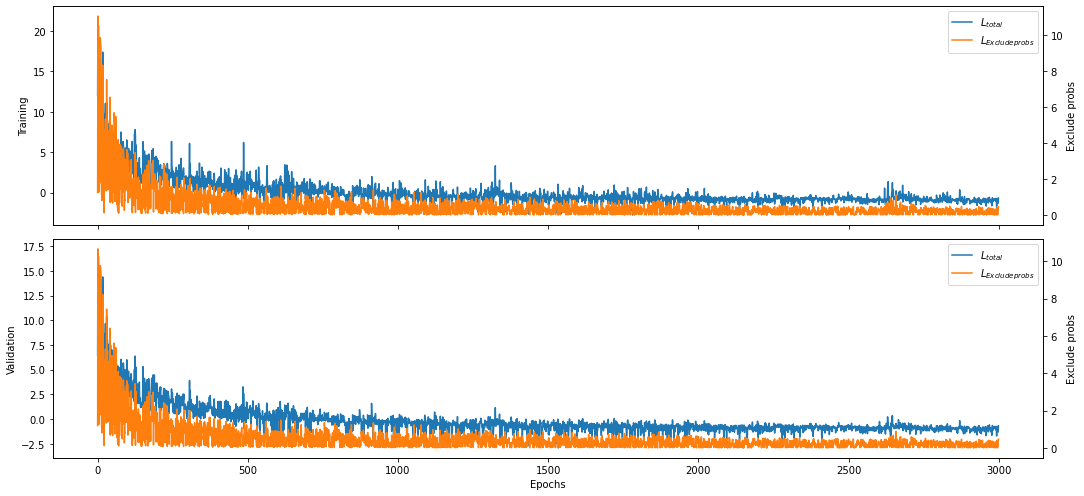

In [9]:
fig,ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
tax0 = ax[0].twinx()
tax0.plot([i.numpy()-j.numpy() for i,j in zip(logger['tr_loss'],logger['tr_probs'])],'tab:orange')
ax[0].plot([i.numpy() for i in logger['tr_loss']])
ax[0].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{Exclude probs}$')
    ]
)
ax[0].set_ylabel('Training')  
tax0.set_ylabel('Exclude probs')   
    
tax1 = ax[1].twinx()
tax1.plot([i.numpy()-j.numpy() for i,j in zip(logger['val_loss'],logger['val_probs'])],'tab:orange')
ax[1].plot([i.numpy() for i in logger['val_loss']])
ax[1].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{Exclude probs}$')
    ]
)
ax[1].set_ylabel('Validation')   
ax[1].set_xlabel('Epochs')   
tax1.set_ylabel('Exclude probs')   

fig.tight_layout()

# Visualization

In [10]:
test_y = labels_val.copy()
test_x = data_val.copy()
som_dim = model.som_dim

test_loader = tf.data.Dataset.from_tensor_slices(test_x).batch(1000)

outputs = []
outputs.append(model(y_data[:,:100]))

Output = [o['cluster_k'] for o in outputs]
Output_dist = [o['z_e_distance'] for o in outputs]

Output_recon_e = [o['x_reconstruction'] for o in outputs]
Output_recon_q = [o['q_reconstruction'] for o in outputs]

dist_all = tf.concat(Output_dist,0).numpy()

z_e (3000, 60)
z_q (3000, 60)


In [11]:
print("out",Output[0].shape)
k_all = tf.concat(Output,0).numpy()
print(k_all)


out (3000,)
[351 370 370 ... 227  91 280]


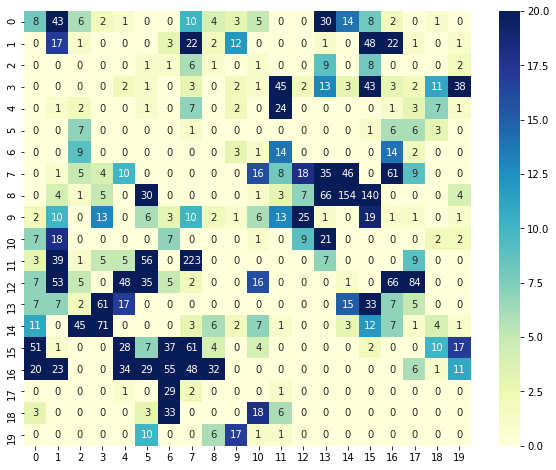

In [12]:
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
ones = np.ones(k_all.shape)

for i in range(som_dim[0]*som_dim[1]):
    
    si = np.where(k_all == i)
    if len(si[0]) > 0:
        clust_matr1[i] = len(si[0])
    
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
fig,ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(clust_matr1, cmap="YlGnBu", vmin=0,vmax=20, annot=True, fmt=".0f", ax = ax)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InvalidArgumentError: Matrix size-incompatible: In[0]: [784,1], In[1]: [30,256] [Op:MatMul]

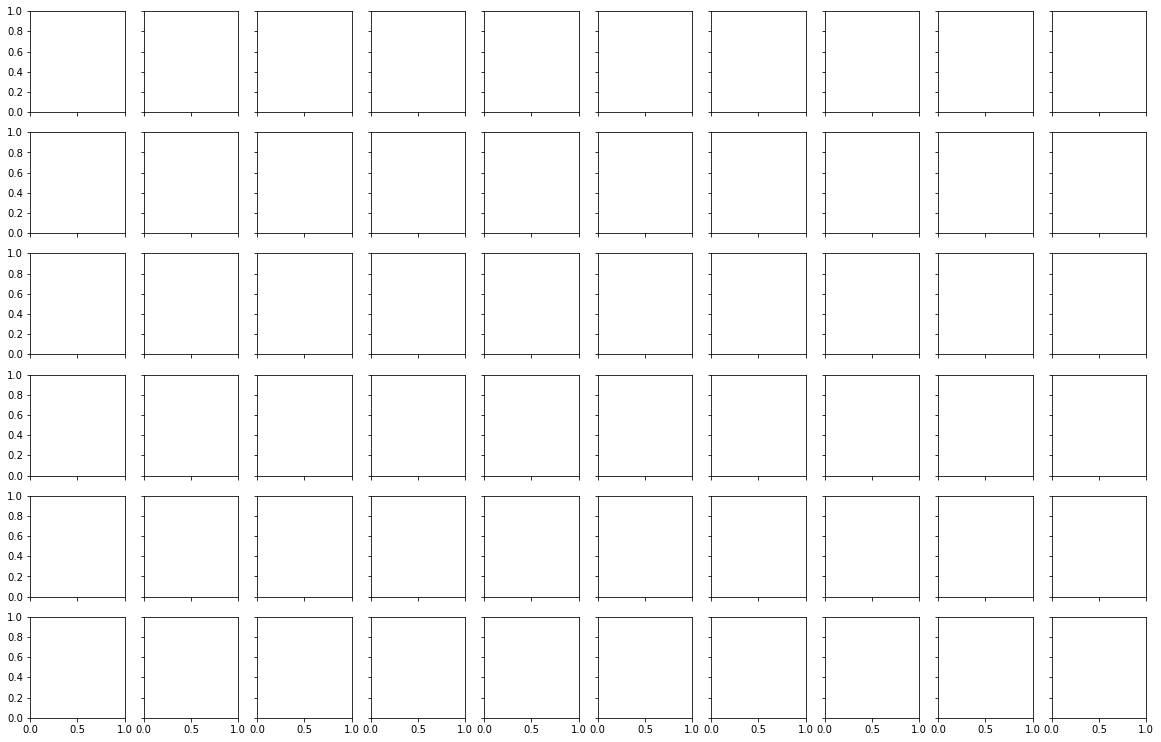

In [13]:
y_test = labels_val.copy()
x_test = data_val.copy()

fig,ax = plt.subplots(6,10,figsize=(20,13),sharex=True,sharey=True)

for number in range(10):
# number = 0
    test_idx = y_test == number
    spec_x_test = x_test[test_idx]
    spec_y_test = y_test[test_idx]
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[0][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[1][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[2][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[3][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[4][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[5][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
ax[0][0].set_ylabel('Real sample 1')
ax[1][0].set_ylabel('Recon sample 1')
ax[2][0].set_ylabel('Recon embed 1')

ax[3][0].set_ylabel('Real sample 2')
ax[4][0].set_ylabel('Recon sample 2')
ax[5][0].set_ylabel('Recon embed 2')

fig.tight_layout()